# 1. Imports & Setup


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ── Aesthetic config ──────────────────────────────────────────────────────────
SAIL_BLUE   = '#003087'
SAIL_RED    = '#C8102E'
SAIL_GOLD   = '#F5A623'
SAIL_GREEN  = '#27AE60'
SAIL_GREY   = '#7F8C8D'
STAGE_COLORS = {'BOF': SAIL_BLUE, 'LF': SAIL_RED}
ALLOY_COLORS = {'FeMn(HC)': '#2C3E50', 'SiMn': '#E67E22', 'FeSi': '#8E44AD'}

plt.rcParams.update({
    'figure.dpi': 140,
    'figure.facecolor': 'white',
    'axes.facecolor': '#F8F9FA',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

print('✅  Libraries loaded successfully')



✅  Libraries loaded successfully


# 2. Data Loading & Preprocessing


In [12]:
# ── DATA LOADING & PREPROCESSING ───────────────────────────────────────────

# Load file with 3-level header
raw = pd.read_excel("Model_RSP.xlsx", header=[0,1,2])

# ── Flatten MultiIndex columns ─────────────────────────────────────────────
raw.columns = [
    "_".join([str(i) for i in col if "Unnamed" not in str(i)]).strip("_")
    for col in raw.columns
]

# Clean column names
raw.columns = (
    raw.columns
        .str.replace(" ", "_", regex=False)
        .str.replace("%", "pct", regex=False)
        .str.replace("-", "_", regex=False)
)

# ── Clean key identifier columns ───────────────────────────────────────────
raw["Date"]    = pd.to_datetime(raw["Date"], errors="coerce")
raw["Heat_Id"] = raw["Heat_Id"].astype(str).str.strip()
raw["Grade"]   = raw["Grade"].astype(str).str.strip()

# ── Convert numeric columns safely ──────────────────────────────────────────
for col in raw.columns:
    if any(keyword in col.upper() for keyword in ["MODEL", "ACTUAL", "FINAL", "MN"]):
        raw[col] = pd.to_numeric(raw[col], errors="coerce")

df = raw.copy()

print("✅ Data Loaded & Preprocessed Successfully")
print(f"   Dataset shape : {df.shape}")
print(f"   Total heats   : {len(df)}")
print(f"   Unique grades : {df['Grade'].nunique()}")
print("\nFirst 5 rows:")
df.head()


✅ Data Loaded & Preprocessed Successfully
   Dataset shape : (37, 16)
   Total heats   : 37
   Unique grades : 9

First 5 rows:


,Date,Heat_Id,Grade,BOF_Model_Recommended_addition_SIMN,BOF_Actual_Addition_SIMN,LHF_Model_Recommended_addition_SIMN,LHF_Model_Recommended_addition_FEMN,LHF_Model_Recommended_addition_FESI,LHF_Model_Recommended_addition_FEV,LHF_Actual_Addition_SIMN,LHF_Actual_Addition_FEMN,LHF_Actual_Addition_FESI,LHF_Actual_Addition_FEV,LHF_Final_Mnpct_in_Caster_As_per_SAP_records,LHF_Final_Mnpct_in_LHF,LHF_Comments
0,2026-01-29,26A01925,250BR14-20,1995,2138,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.84,0.79,NaN
1,2026-01-29,26A01927,250BR12-20,1953,2006,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.83,0.82,NaN
2,2026-01-29,26A01929,250BR12-20,1995,2047,158,0.0,0.0,0.0,170,0.0,0.0,0.0,0.78,0.78,NaN
3,2026-01-30,26A01982,GR1,284,400,224,0.0,0.0,0.0,240,0.0,0.0,0.0,0.27,0.27,NaN
4,2026-01-30,26A01984,250BR5-10,1974,2153,31,0.0,0.0,0.0,20,0.0,0.0,0.0,0.77,0.76,NaN


# 3. MODEL ACCURACY METRICS 

In [13]:


def compute_metrics(model_col, actual_col, label):
    m = df[model_col].dropna()
    a = df[actual_col].dropna()

    idx = m.index.intersection(a.index)
    m, a = m[idx], a[idx]

    # Only heats where at least one of model/actual is non-zero
    mask = (m != 0) | (a != 0)
    m, a = m[mask], a[mask]

    if len(m) < 2:
        return None

    mae  = mean_absolute_error(a, m)
    rmse = np.sqrt(mean_squared_error(a, m))
    r2   = r2_score(a, m)
    mape = np.mean(np.abs((a - m) / np.where(m != 0, m, np.nan))) * 100

    tolerance = np.maximum(0.10 * m.abs(), 100)
    hit = ((a - m).abs() <= tolerance).mean() * 100

    return {
        'Alloy/Stage': label,
        'N': len(m),
        'MAE (kg)': round(mae, 1),
        'RMSE (kg)': round(rmse, 1),
        'R²': round(r2, 3),
        'MAPE (%)': round(mape, 1),
        'Hit Rate (%)': round(hit, 1)
    }

rows = []

labels_map = [
    ('BOF_Model_Recommended_addition_SIMN',
     'BOF_Actual_Addition_SIMN',
     'BOF – SiMn'),

    ('LHF_Model_Recommended_addition_SIMN',
     'LHF_Actual_Addition_SIMN',
     'LHF – SiMn'),

    ('LHF_Model_Recommended_addition_FEMN',
     'LHF_Actual_Addition_FEMN',
     'LHF – FeMn'),

    ('LHF_Model_Recommended_addition_FESI',
     'LHF_Actual_Addition_FESI',
     'LHF – FeSi'),
]

for mc, ac, lbl in labels_map:
    if mc in df.columns and ac in df.columns:
        r = compute_metrics(mc, ac, lbl)
        if r:
            rows.append(r)

metrics_df = pd.DataFrame(rows)

print('=' * 65)
print('         FERROALLOY ADDITION MODEL ACCURACY METRICS')
print('=' * 65)
print(metrics_df.to_string(index=False))
print('=' * 65)


         FERROALLOY ADDITION MODEL ACCURACY METRICS
Alloy/Stage  N  MAE (kg)  RMSE (kg)    R²  MAPE (%)  Hit Rate (%)
 BOF – SiMn 37     108.1      129.6 0.916       7.5          89.2
 LHF – SiMn 35     139.4      326.0 0.720      10.8          80.0
 LHF – FeMn  7     223.3      416.1 0.293      68.3          71.4


In [15]:
# Mn% summary (no Mn_Min_Grade in RSP file)

final_mn_col = 'LHF_Final_Mnpct_in_LHF'

if final_mn_col in df.columns:
    print(f"Final Mn% – Mean  : {df[final_mn_col].mean():.4f}")
    print(f"Final Mn% – Std   : {df[final_mn_col].std():.4f}")
    print(f"Final Mn% – Min   : {df[final_mn_col].min():.4f}")
    print(f"Final Mn% – Max   : {df[final_mn_col].max():.4f}")


Final Mn% – Mean  : 0.9917
Final Mn% – Std   : 0.2848
Final Mn% – Min   : 0.2700
Final Mn% – Max   : 1.4700


# 4. GRADE DISTRIBUTION & TRIAL TIMELINE 

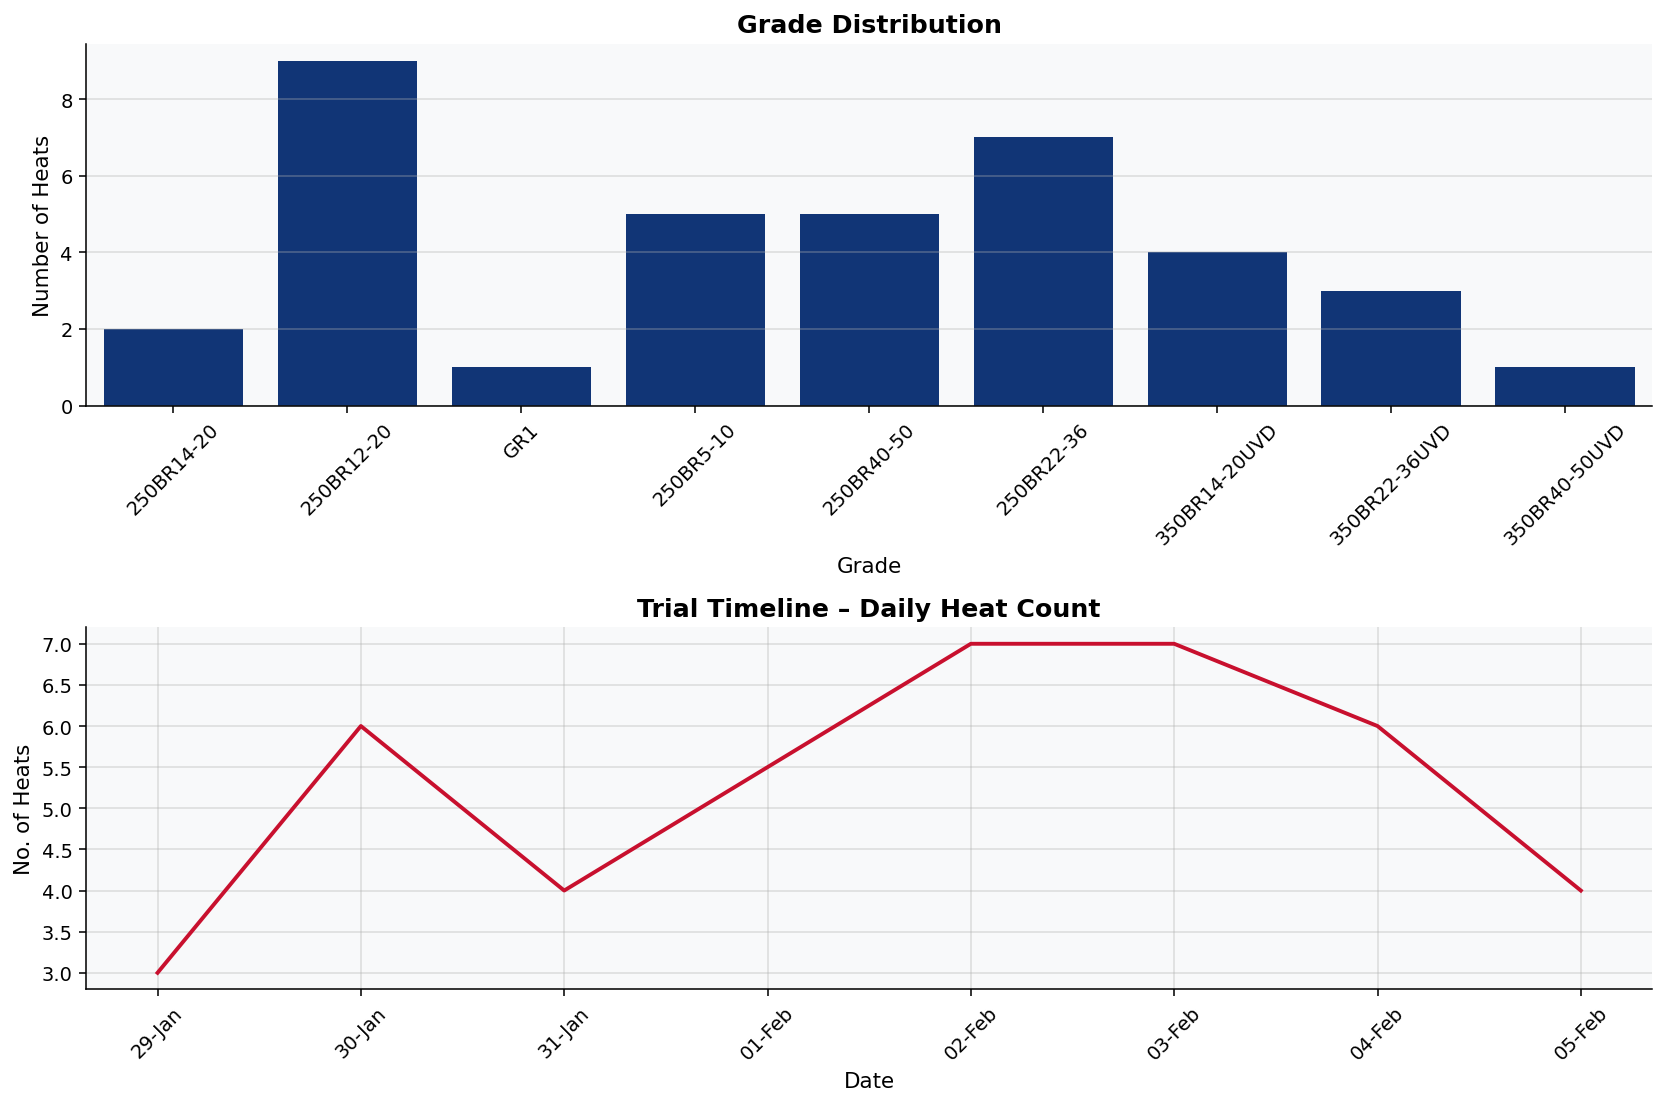

In [21]:


import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 1, figsize=(12,8))

# ── 1️⃣ Grade Distribution ─────────────────────────────────────────────
sns.countplot(data=df, x='Grade', ax=axes[0], color=SAIL_BLUE)

axes[0].set_title('Grade Distribution', weight='bold')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Number of Heats')
axes[0].tick_params(axis='x', rotation=45)


# ── 2️⃣ Trial Timeline (Heats per Day) ─────────────────────────────────

if 'Date' in df.columns:
    
    daily_counts = df.groupby('Date').size()

    axes[1].plot(daily_counts.index, daily_counts.values,
                 color=SAIL_RED, linewidth=2)

    axes[1].set_title('Trial Timeline – Daily Heat Count', weight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('No. of Heats')

    axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 5. MODEL vs ACTUAL — BOF FERROALLOY ADDITIONS 

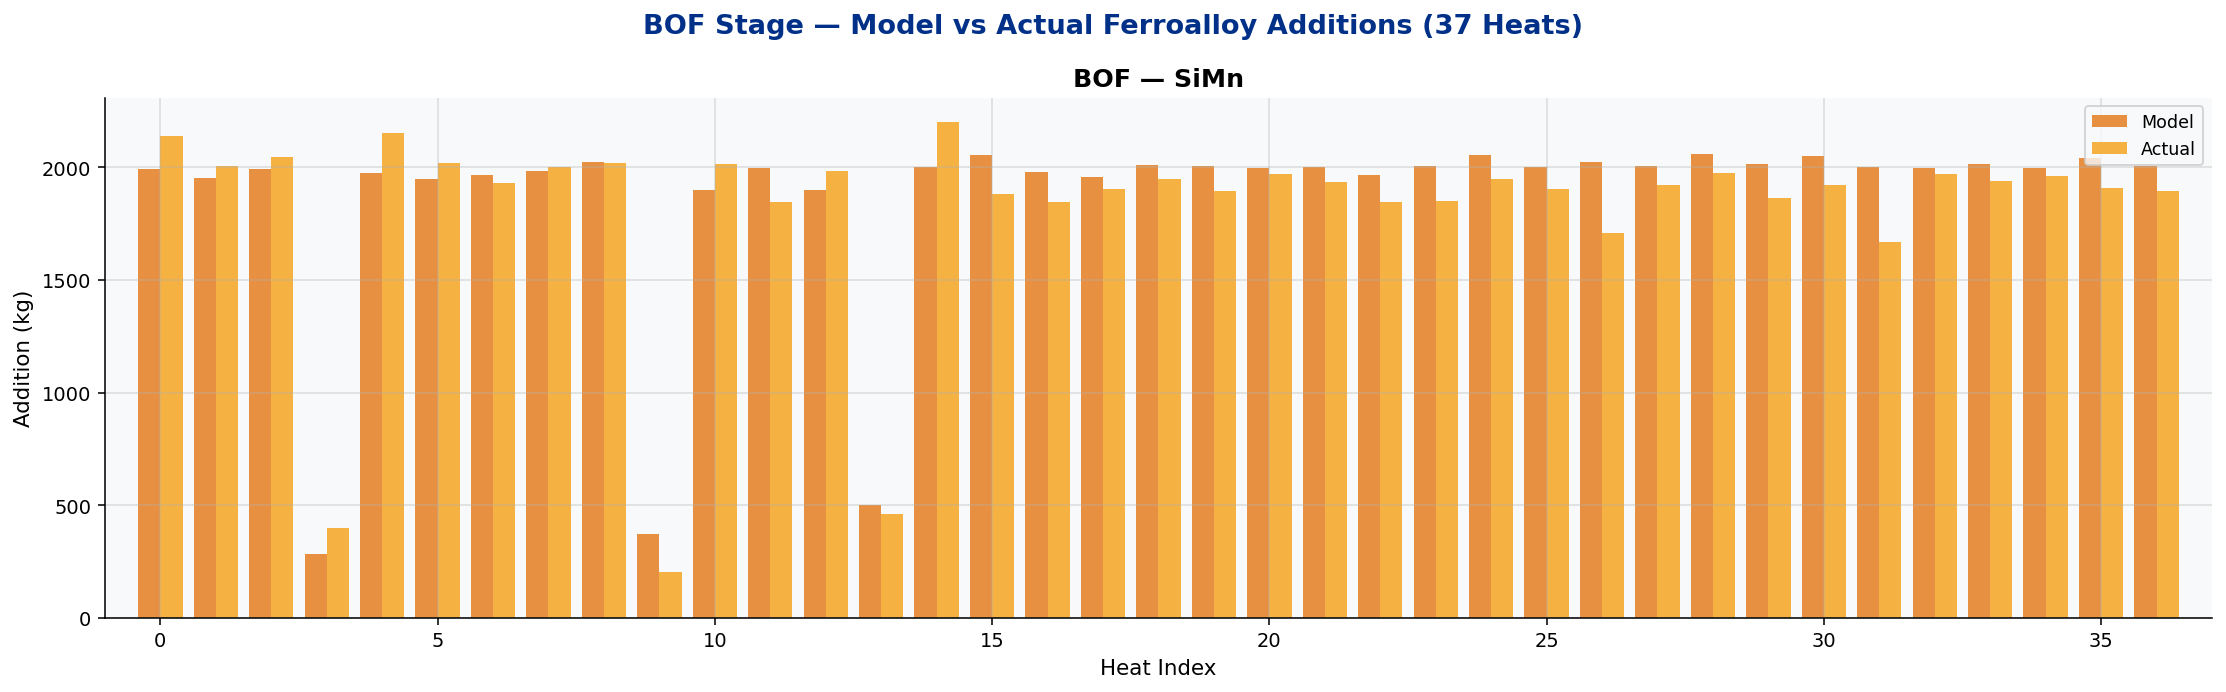

In [22]:


def plot_model_vs_actual_bar(stage, alloy_key, model_col, actual_col, ax, color):
    x = np.arange(len(df))
    w = 0.4

    ax.bar(x - w/2, df[model_col],  w,
           label='Model',
           color=color,
           alpha=0.85,
           edgecolor='none')

    ax.bar(x + w/2, df[actual_col], w,
           label='Actual',
           color=SAIL_GOLD,
           alpha=0.85,
           edgecolor='none')

    ax.set_title(f'{stage} — {alloy_key}', fontweight='bold')
    ax.set_xlabel('Heat Index')
    ax.set_ylabel('Addition (kg)')
    ax.legend(fontsize=9)
    ax.set_xlim(-1, len(df))


# BOF in RSP file only has SIMN
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

plot_model_vs_actual_bar(
    'BOF',
    'SiMn',
    'BOF_Model_Recommended_addition_SIMN',
    'BOF_Actual_Addition_SIMN',
    ax,
    ALLOY_COLORS['SiMn']
)

plt.suptitle(
    f'BOF Stage — Model vs Actual Ferroalloy Additions ({len(df)} Heats)',
    fontsize=14,
    fontweight='bold',
    color=SAIL_BLUE
)

plt.tight_layout()
plt.show()


# 6.MODEL vs ACTUAL — LHF FERROALLOY ADDITIONS 

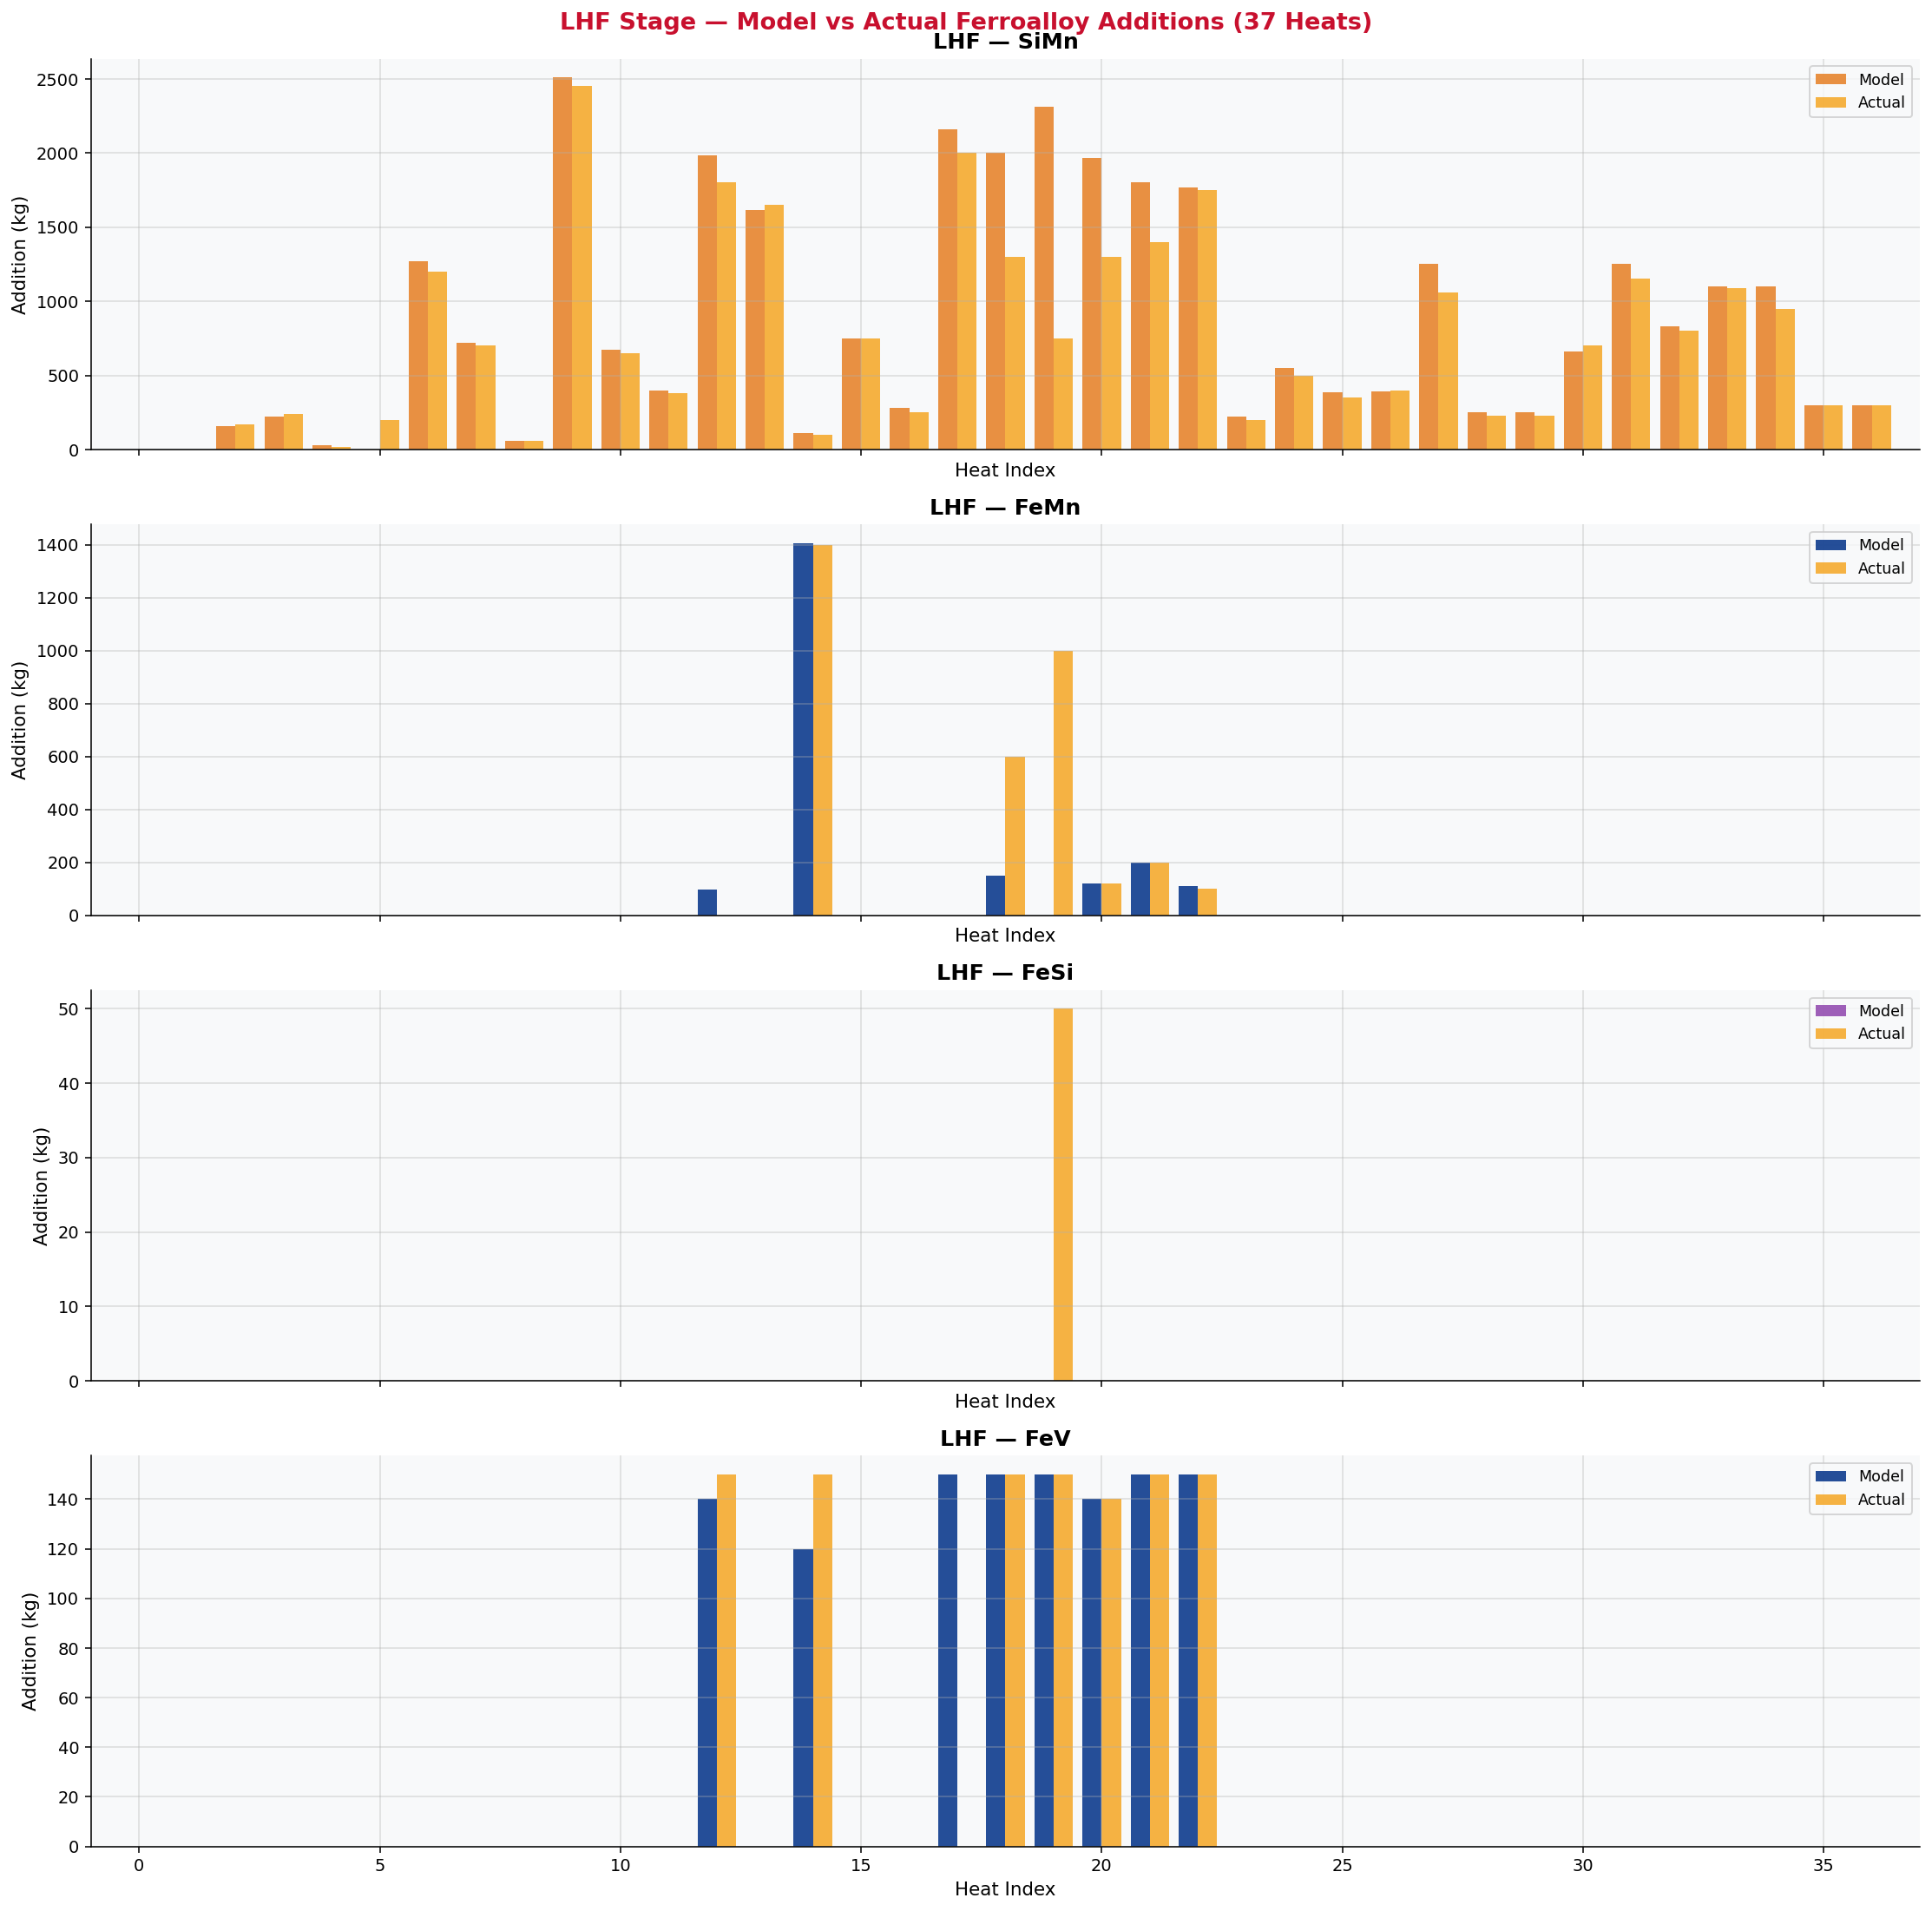

In [23]:


fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

lhf_alloys = [
    ('SiMn',
     'LHF_Model_Recommended_addition_SIMN',
     'LHF_Actual_Addition_SIMN'),

    ('FeMn',
     'LHF_Model_Recommended_addition_FEMN',
     'LHF_Actual_Addition_FEMN'),

    ('FeSi',
     'LHF_Model_Recommended_addition_FESI',
     'LHF_Actual_Addition_FESI'),

    ('FeV',
     'LHF_Model_Recommended_addition_FEV',
     'LHF_Actual_Addition_FEV'),
]

for ax, (alloy, mc, ac) in zip(axes, lhf_alloys):
    
    if mc in df.columns and ac in df.columns:
        plot_model_vs_actual_bar(
            'LHF',
            alloy,
            mc,
            ac,
            ax,
            ALLOY_COLORS.get(alloy, SAIL_BLUE)
        )

plt.suptitle(
    f'LHF Stage — Model vs Actual Ferroalloy Additions ({len(df)} Heats)',
    fontsize=14,
    fontweight='bold',
    color=SAIL_RED
)

plt.tight_layout()
plt.show()


# 7.SCATTER PLOT — MODEL vs ACTUAL

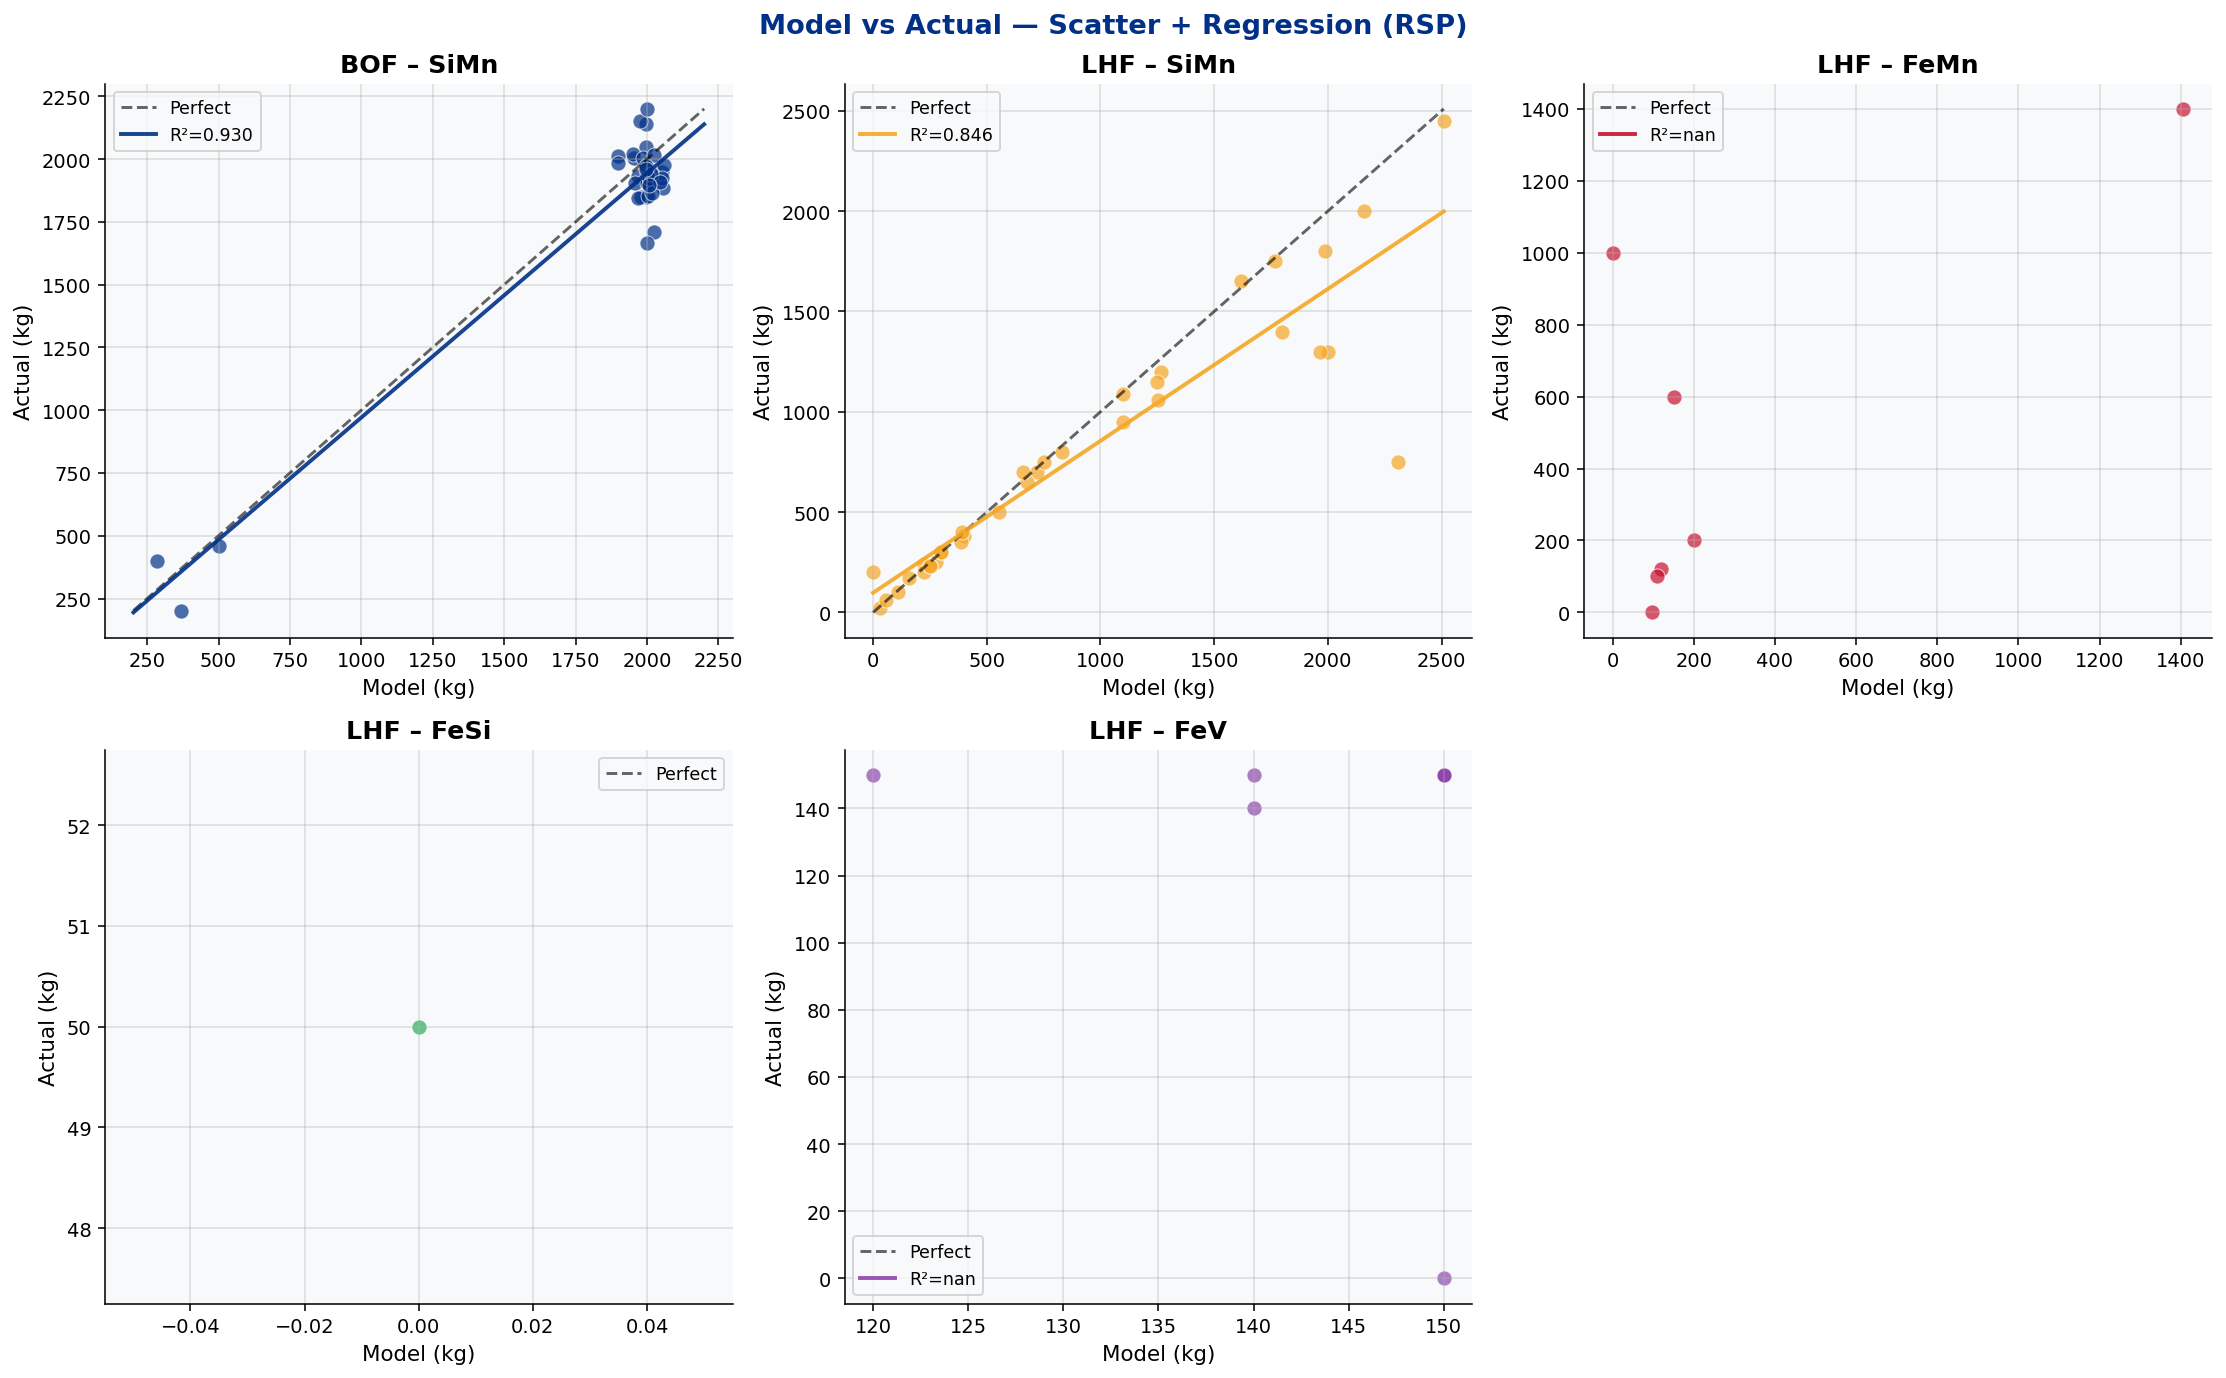

In [24]:


fig, axes = plt.subplots(2, 3, figsize=(16, 10))

all_alloys = [
    ('BOF – SiMn',
     'BOF_Model_Recommended_addition_SIMN',
     'BOF_Actual_Addition_SIMN',
     SAIL_BLUE),

    ('LHF – SiMn',
     'LHF_Model_Recommended_addition_SIMN',
     'LHF_Actual_Addition_SIMN',
     SAIL_GOLD),

    ('LHF – FeMn',
     'LHF_Model_Recommended_addition_FEMN',
     'LHF_Actual_Addition_FEMN',
     SAIL_RED),

    ('LHF – FeSi',
     'LHF_Model_Recommended_addition_FESI',
     'LHF_Actual_Addition_FESI',
     '#27AE60'),

    ('LHF – FeV',
     'LHF_Model_Recommended_addition_FEV',
     'LHF_Actual_Addition_FEV',
     '#8E44AD'),
]

for ax, (title, mc, ac, color) in zip(axes.flat, all_alloys):

    if mc not in df.columns or ac not in df.columns:
        ax.axis('off')
        continue

    m_vals = df[mc].values
    a_vals = df[ac].values

    mask = (m_vals != 0) | (a_vals != 0)
    m_plot, a_plot = m_vals[mask], a_vals[mask]

    if len(m_plot) == 0:
        ax.text(0.5, 0.5, 'No additions\nin this stage',
                ha='center', va='center',
                transform=ax.transAxes,
                fontsize=11,
                color=SAIL_GREY)
        ax.set_title(title, fontweight='bold')
        continue

    ax.scatter(m_plot, a_plot,
               color=color,
               alpha=0.7,
               s=60,
               edgecolors='white',
               linewidth=0.5)

    mn = min(m_plot.min(), a_plot.min())
    mx = max(m_plot.max(), a_plot.max())

    # Perfect prediction line
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1.5, alpha=0.6, label='Perfect')

    # Regression line
    if len(m_plot) > 2:
        slope, intercept, r_val, *_ = stats.linregress(m_plot, a_plot)
        x_fit = np.linspace(mn, mx, 100)
        ax.plot(x_fit,
                slope * x_fit + intercept,
                color=color,
                lw=2,
                alpha=0.9,
                label=f'R²={r_val**2:.3f}')

    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Model (kg)')
    ax.set_ylabel('Actual (kg)')
    ax.legend(fontsize=9)

# Hide unused subplot (since we have 5 alloys but 6 panels)
axes.flat[-1].axis('off')

plt.suptitle(
    'Model vs Actual — Scatter + Regression (RSP)',
    fontsize=14,
    fontweight='bold',
    color=SAIL_BLUE
)

plt.tight_layout()
plt.show()

# 8.RESIDUAL ERROR ANALYSIS (CREATE + PLOT) 

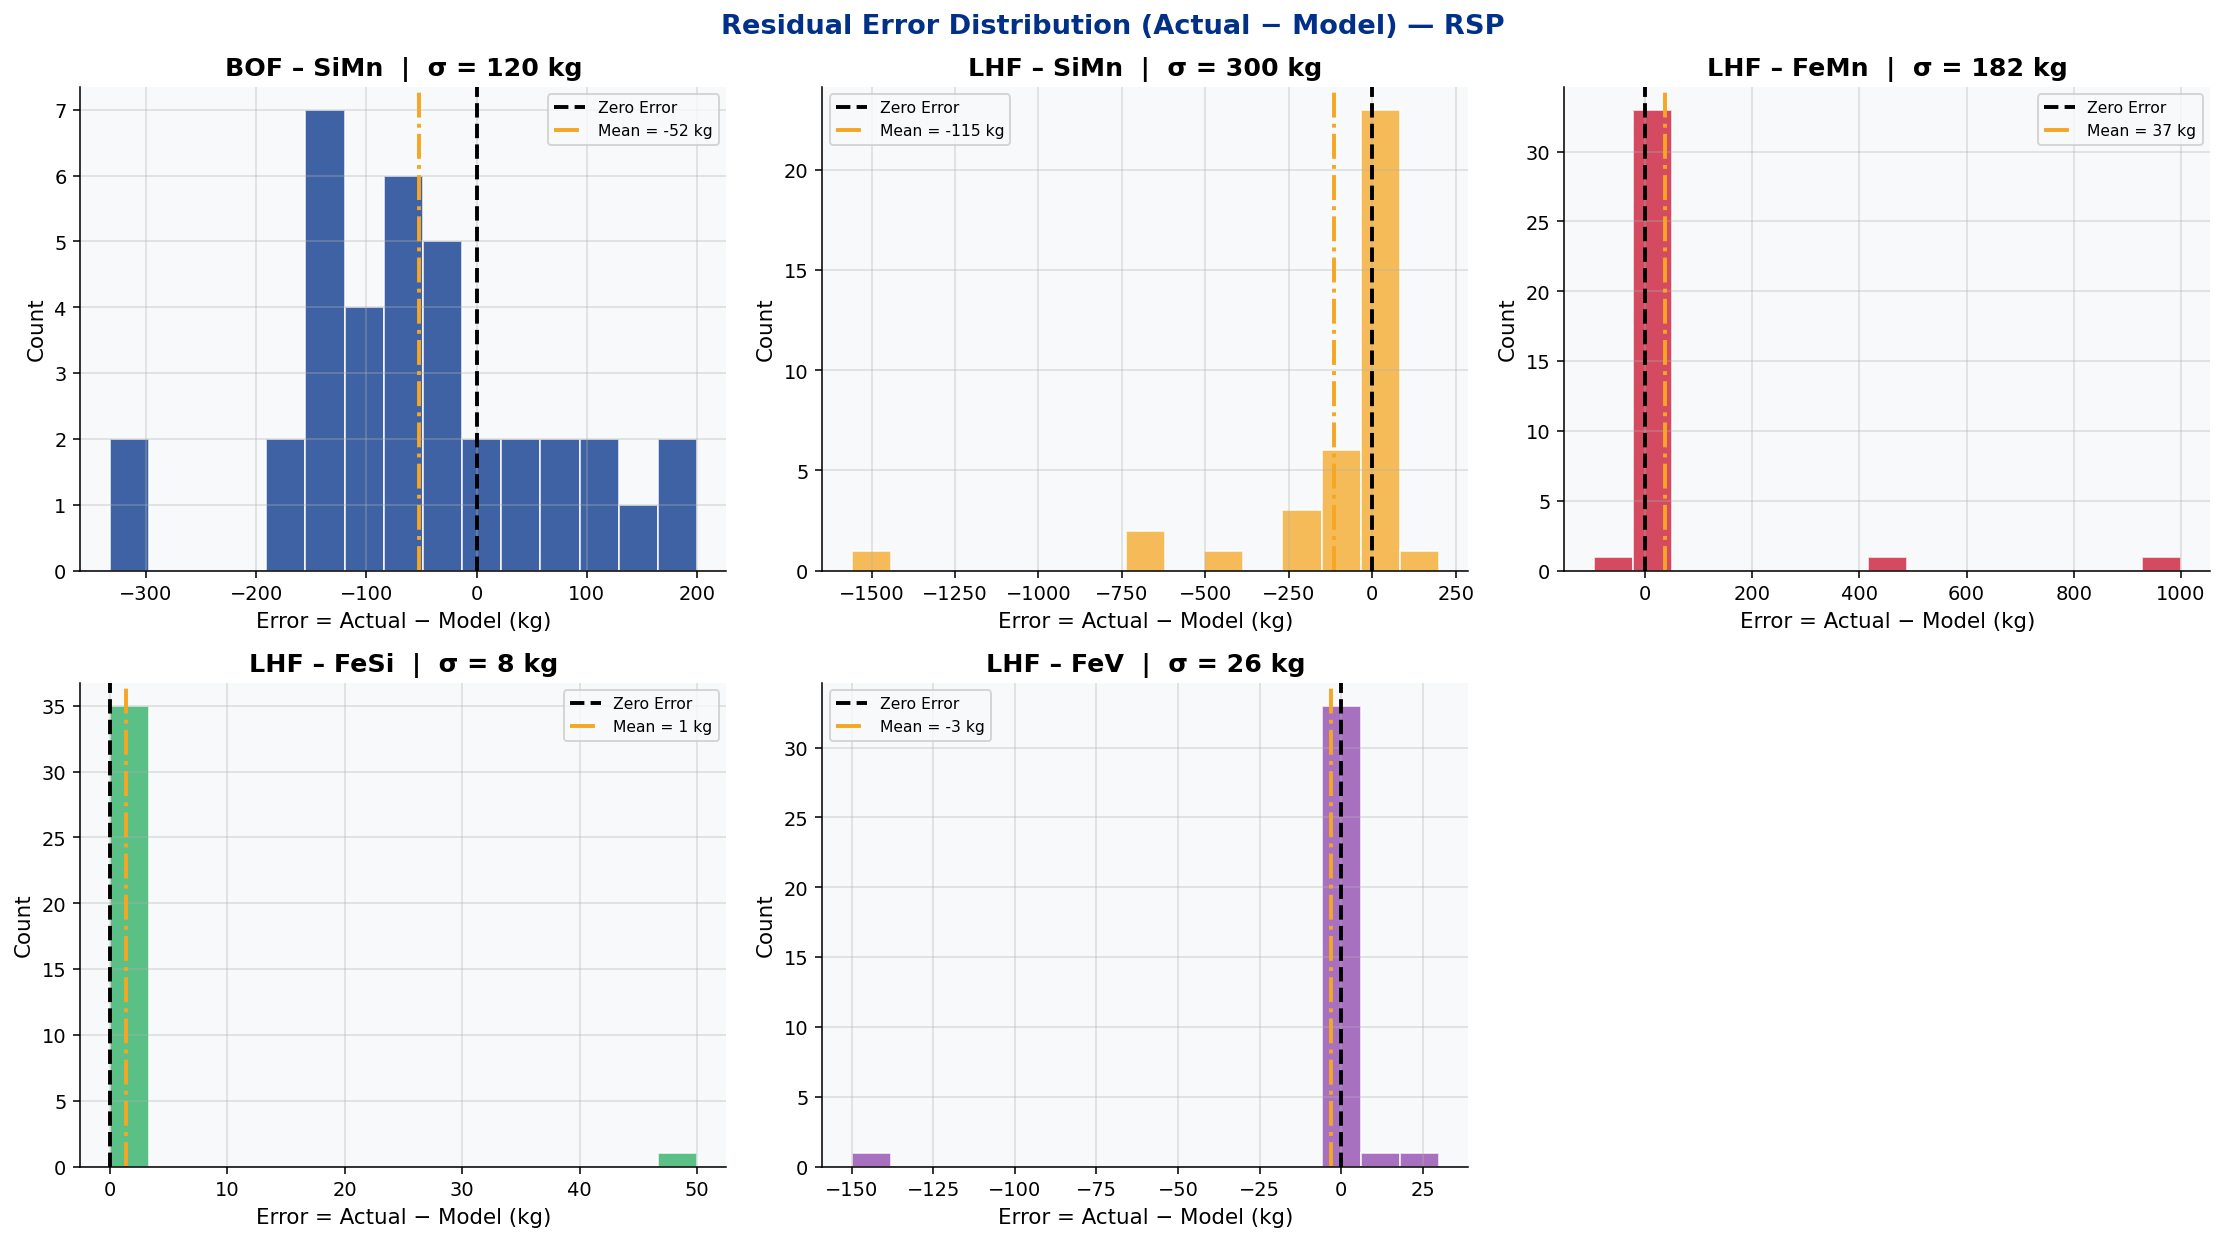

In [27]:


# Create error columns (Actual − Model)
error_pairs = [
    ('BOF_Model_Recommended_addition_SIMN',
     'BOF_Actual_Addition_SIMN',
     'BOF_SiMn_Error'),

    ('LHF_Model_Recommended_addition_SIMN',
     'LHF_Actual_Addition_SIMN',
     'LHF_SiMn_Error'),

    ('LHF_Model_Recommended_addition_FEMN',
     'LHF_Actual_Addition_FEMN',
     'LHF_FeMn_Error'),

    ('LHF_Model_Recommended_addition_FESI',
     'LHF_Actual_Addition_FESI',
     'LHF_FeSi_Error'),

    ('LHF_Model_Recommended_addition_FEV',
     'LHF_Actual_Addition_FEV',
     'LHF_FeV_Error'),
]

for mc, ac, err_name in error_pairs:
    if mc in df.columns and ac in df.columns:
        df[err_name] = df[ac] - df[mc]


# Plot residual distributions
error_cols = [
    ('BOF_SiMn_Error',  'BOF – SiMn',  SAIL_BLUE),
    ('LHF_SiMn_Error',  'LHF – SiMn',  SAIL_GOLD),
    ('LHF_FeMn_Error',  'LHF – FeMn',  SAIL_RED),
    ('LHF_FeSi_Error',  'LHF – FeSi',  '#27AE60'),
    ('LHF_FeV_Error',   'LHF – FeV',   '#8E44AD'),
]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for ax, (col, title, color) in zip(axes.flat, error_cols):

    if col not in df.columns:
        ax.axis('off')
        continue

    data = df[col].dropna()

    if len(data) == 0:
        ax.axis('off')
        continue

    ax.hist(data, bins=15,
            color=color,
            alpha=0.75,
            edgecolor='white')

    ax.axvline(0, color='black', lw=2, linestyle='--', label='Zero Error')

    ax.axvline(data.mean(),
               color=SAIL_GOLD,
               lw=2,
               linestyle='-.',
               label=f"Mean = {data.mean():.0f} kg")

    ax.set_title(f"{title}  |  σ = {data.std():.0f} kg",
                 fontweight='bold')

    ax.set_xlabel('Error = Actual − Model (kg)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)

# Hide unused subplot
axes.flat[-1].axis('off')

plt.suptitle(
    'Residual Error Distribution (Actual − Model) — RSP',
    fontsize=14,
    fontweight='bold',
    color=SAIL_BLUE
)

plt.tight_layout()
plt.show()


# 9. ABSOLUTE ERROR TREND (CREATE + PLOT) 

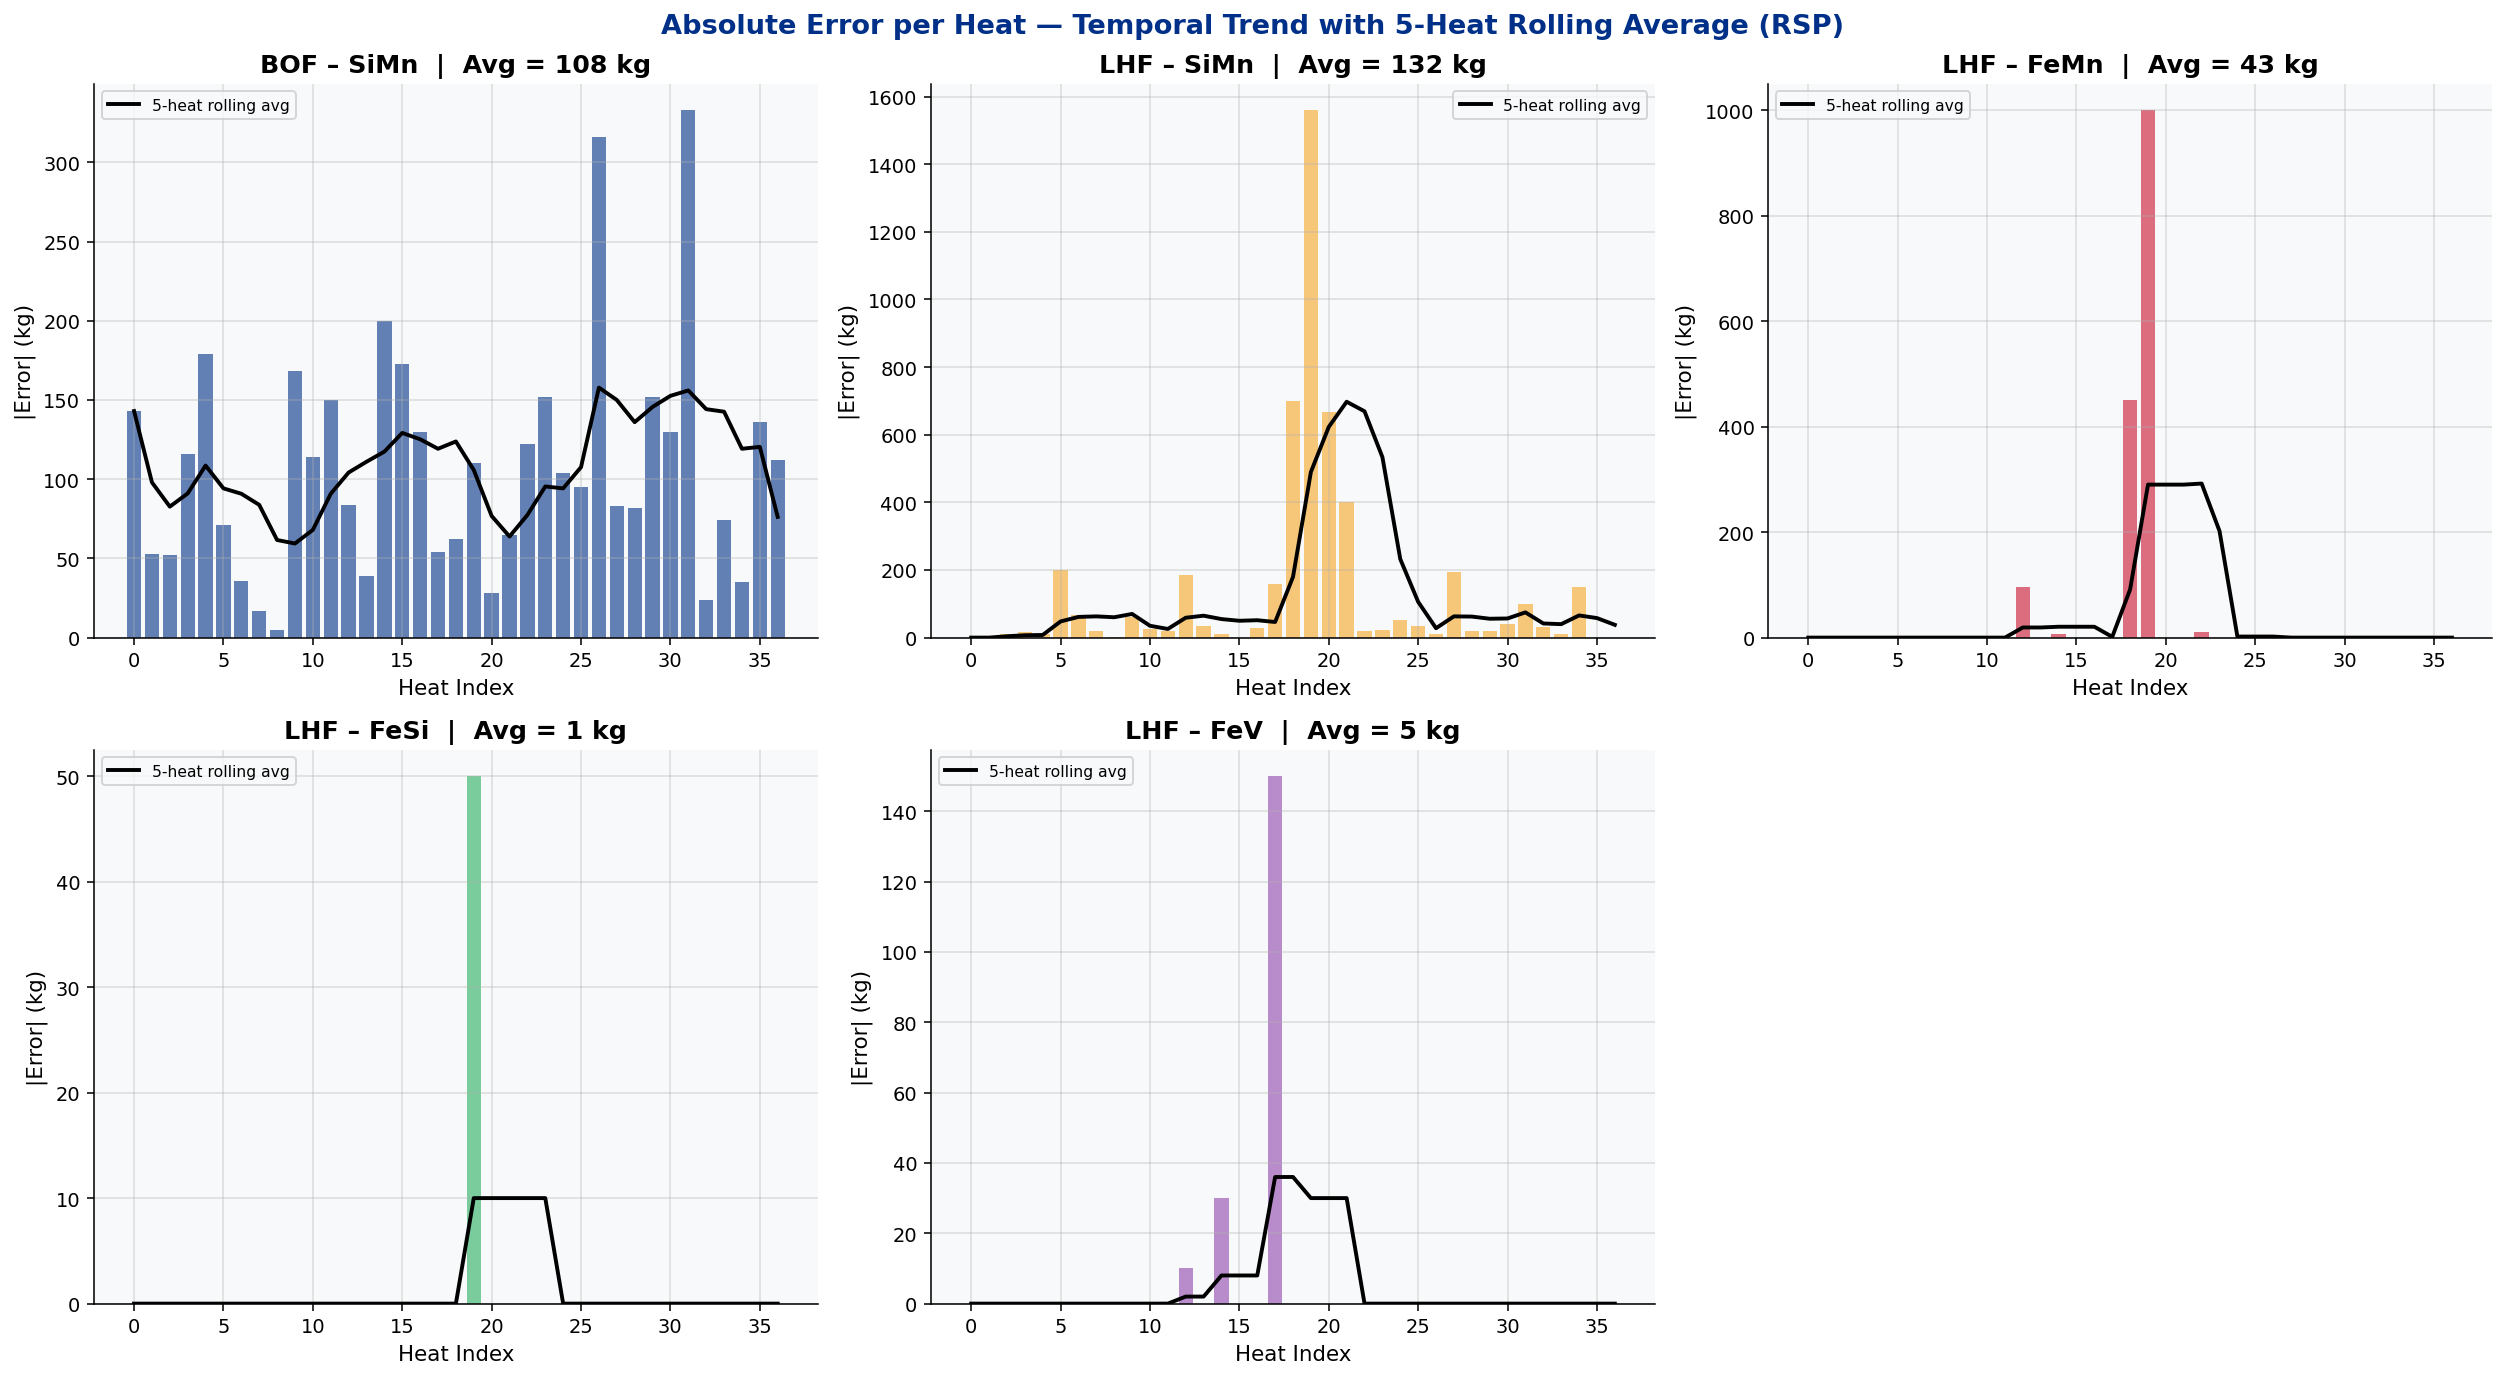

In [28]:


# Create absolute error columns
abs_error_pairs = [
    ('BOF_SiMn_Error',  'BOF_SiMn_AbsErr'),
    ('LHF_SiMn_Error',  'LHF_SiMn_AbsErr'),
    ('LHF_FeMn_Error',  'LHF_FeMn_AbsErr'),
    ('LHF_FeSi_Error',  'LHF_FeSi_AbsErr'),
    ('LHF_FeV_Error',   'LHF_FeV_AbsErr'),
]

for err_col, abs_col in abs_error_pairs:
    if err_col in df.columns:
        df[abs_col] = df[err_col].abs()


# Plot temporal absolute error trends
abs_err_cols = [
    ('BOF_SiMn_AbsErr', 'BOF – SiMn',  SAIL_BLUE),
    ('LHF_SiMn_AbsErr', 'LHF – SiMn',  SAIL_GOLD),
    ('LHF_FeMn_AbsErr', 'LHF – FeMn',  SAIL_RED),
    ('LHF_FeSi_AbsErr', 'LHF – FeSi',  '#27AE60'),
    ('LHF_FeV_AbsErr',  'LHF – FeV',   '#8E44AD'),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)

for ax, (col, title, color) in zip(axes.flat, abs_err_cols):

    if col not in df.columns:
        ax.axis('off')
        continue

    y = df[col].values
    x = np.arange(len(y))

    ax.bar(x, y,
           color=color,
           alpha=0.6,
           width=0.8,
           edgecolor='none')

    # Rolling mean trend
    roll = pd.Series(y).rolling(5, min_periods=1).mean()
    ax.plot(x, roll,
            color='black',
            lw=2,
            label='5-heat rolling avg')

    ax.set_title(f"{title}  |  Avg = {np.nanmean(y):.0f} kg",
                 fontweight='bold')

    ax.set_xlabel('Heat Index')
    ax.set_ylabel('|Error| (kg)')
    ax.legend(fontsize=8)

# Hide unused panel
axes.flat[-1].axis('off')

plt.suptitle(
    'Absolute Error per Heat — Temporal Trend with 5-Heat Rolling Average (RSP)',
    fontsize=14,
    fontweight='bold',
    color=SAIL_BLUE
)

plt.tight_layout()
plt.show()
